In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from utils import generator, read_batch
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch.autograd import Variable
from torch import LongTensor, FloatTensor
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from utils import read_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
p_file_idxes = 'data/file_idxes.npy'
p_tokenizer = 'data/tokenizer.pickle'
p_label2idx = 'data/label2idx.pickle'
p_label_counter = 'data/label_counter'
p_word_vectors = './data/word_vectors.npy'
data_path = './data'

In [9]:
EMBEDDING_DIM = 200

    Read variables

In [97]:
file_idxes = np.load(p_file_idxes)
word_vectors = np.load(p_word_vectors)
with open(p_label2idx, 'rb') as f:
    label2idx = pickle.load(f)
with open(p_label_counter, 'rb') as f:
    label_counter = pickle.load(f)
with open(p_tokenizer, 'rb') as f:
    tokenizer = pickle.load(f)

    Make Dataset instance and define model

In [90]:
class TextsDataset(Dataset):
    def __init__(self, file_idxes, data_path, label2idx):
        self.file_idxes = file_idxes
        self.data_path = data_path
        self.label2idx = label2idx
        
    def __len__(self):
        return len(self.file_idxes)
    
    def __getitem__(self, idx):
        batch_x, batch_y = read_batch(self.data_path, self.file_idxes[idx], self.label2idx)
        return LongTensor(batch_x), FloatTensor(batch_y)

In [91]:
class ConvClassifier(nn.Module):
    def __init__(self, kernel_size, n_filters, embedding_dim, word_vectors, n_labels, freeze_embeds=True):
        super(ConvClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_vectors, freeze_embeds)
        self.conv = nn.Conv2d(1, n_filters, [kernel_size, embedding_dim])
        self.linear = nn.Linear(n_filters, n_labels)
        
    def forward(self, batch_in):
        batch_in = torch.unsqueeze(batch_in, 1)
        print(batch_in.size())
        x = self.embedding(batch_in)
        print(x.size())
        x = self.conv(x)
        print(x.size())
        x = torch.squeeze(x, -1)
        print(x.size())
        x = nn.MaxPool1d(x.size()[2])(x)
        print(x.size())
        x = torch.squeeze(x, 2)
        print(x.size())
        logits = self.linear(x)
        return logits

    Init model and dataloader and train

In [95]:
dataset = TextsDataset(file_idxes, data_path, label2idx)
dataloader = DataLoader(dataset, num_workers=1, collate_fn=lambda l: l[0])
clf = ConvClassifier(2, 10, 200, FloatTensor(word_vectors), len(label2idx))
optimizer = Adam(filter(lambda p: p.requires_grad, clf.parameters()))
criterion = nn.BCEWithLogitsLoss()

for batch_x, batch_y in dataloader:
    logits = clf(batch_x)
    loss = criterion(logits, batch_y)
    print(loss.data.numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

torch.Size([4, 1, 2])
torch.Size([4, 1, 2, 200])
torch.Size([4, 10, 1, 1])
torch.Size([4, 10, 1])
torch.Size([4, 10, 1])
torch.Size([4, 10])
0.7032218


    Check batch_normalization

In [100]:
import tensorflow as tf

In [101]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [117]:
def batch_gen(data, labels, batch_size):
    while True:
        idxes = np.arange(len(data))
        np.random.shuffle(idxes)
        for start_idx in range(0, len(data), batch_size):
            end_idx = min(start_idx + batch_size, len(data))
            yield FloatTensor(data[start_idx : end_idx]), LongTensor(labels[start_idx : end_idx])

In [189]:
class MnistTestModel(nn.Module):
    def __init__(self, use_bn):
        super(MnistTestModel, self).__init__()
        self.use_bn = use_bn
        self.linear1 = nn.Linear(784, 100, bias=not use_bn)
        self.linear2 = nn.Linear(100, 100, bias=not use_bn)
        if self.use_bn:
            self.batch_norm = nn.BatchNorm1d(100, 1e-3, 0.01)
        
        self.linear_out = nn.Linear(100, 10)
        
    def forward(self, batch_x):
        x = self.linear1(batch_x)
        x = self.linear2(x)
        if self.use_bn:
            x = self.batch_norm(x)
        x = self.linear_out(x)
        return nn.functional.log_softmax(x, dim=1)

In [190]:
model_bn = MnistTestModel(True)
model_nbn = MnistTestModel(False)
criterion = nn.NLLLoss()
optimizer_bn = Adam(model_bn.parameters(), lr=0.01)
optimizer_nbn = Adam(model_nbn.parameters(), lr=0.01)



In [191]:
%%time

tn_losses_bn = []
eval_losses_bn = []
tn_losses_nbn = []
eval_losses_nbn = []

tn_accs_bn = []
eval_accs_bn = []
tn_accs_nbn = []
eval_accs_nbn = []

train_gen = batch_gen(train_data, train_labels, 60)
eval_gen = batch_gen(eval_data, eval_labels, 100)

for i in tqdm_notebook(range(1, 10001)):

    batch_x, batch_y = next(train_gen)

    lbn, abn = step(model_bn, batch_x, batch_y, optimizer_bn)
    lnbn, anbn = step(model_nbn, batch_x, batch_y, optimizer_nbn)

    tn_losses_bn.append(lbn)
    tn_losses_nbn.append(lnbn)
    tn_accs_bn.append(abn)
    tn_accs_nbn.append(anbn)

    if i % 500 == 0:
        model_bn.eval()
        model_nbn.eval()

        full_loss_bn, full_right_bn = 0, 0
        full_loss_nbn, full_right_nbn = 0, 0
        fake_full_loss_bn, fake_full_right_bn = 0, 0

        for _ in range(100):
            batch_x, batch_y = next(eval_gen)
            lbn, abn = step(model_bn, batch_x, batch_y)
            lnbn, anbn = step(model_nbn, batch_x, batch_y)

            full_loss_bn += lbn
            full_right_bn += 100 * abn

            full_loss_nbn += lnbn
            full_right_nbn += 100 * anbn

        eval_losses_bn.append(full_loss_bn / 100)
        eval_losses_nbn.append(full_loss_nbn / 100)
        eval_accs_bn.append(full_right_bn / 10000)
        eval_accs_nbn.append(full_right_nbn / 10000)
        
        model_bn.train()
        model_nbn.train()


CPU times: user 3min 32s, sys: 39.2 s, total: 4min 11s
Wall time: 35.4 s


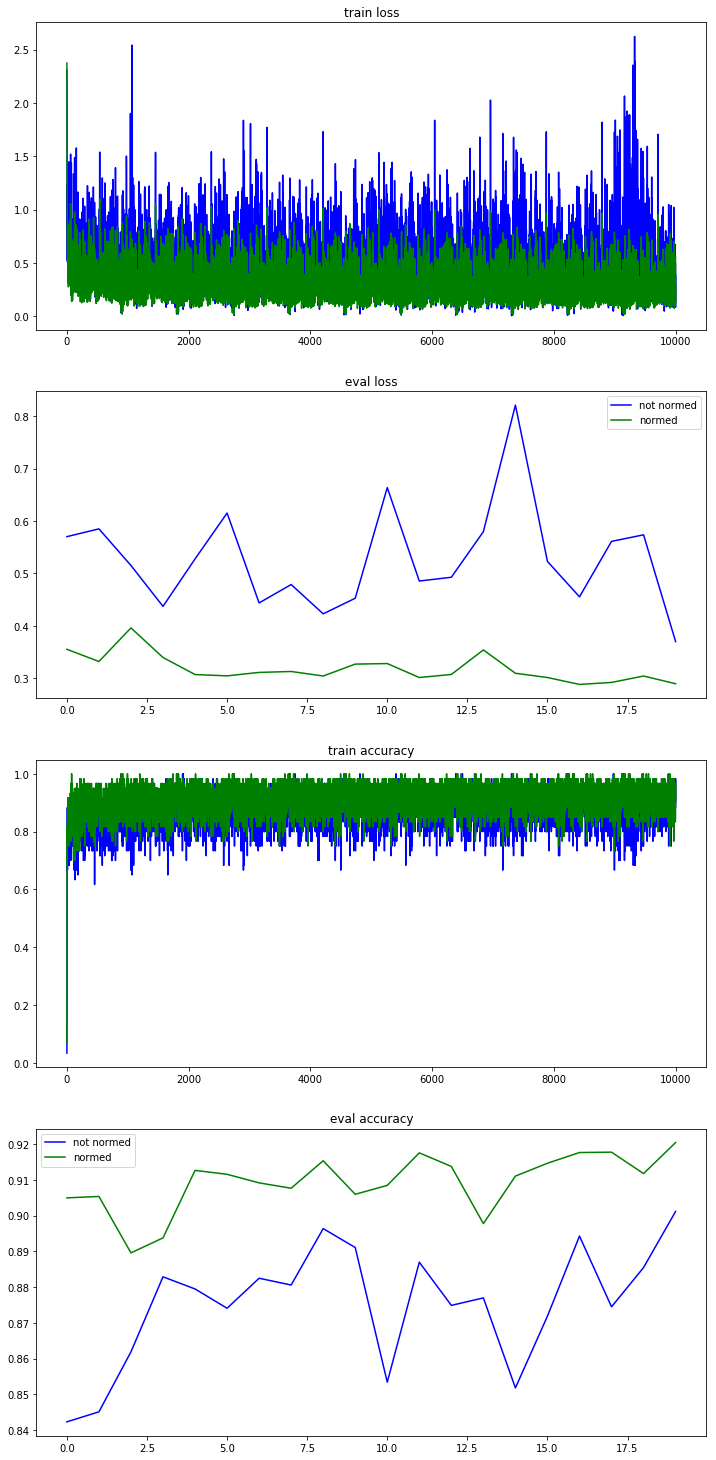

In [192]:
fig, axes = plt.subplots(4, figsize=[12, 26])

axes[0].set_title('train loss')
axes[0].plot(tn_losses_nbn, c='b')
axes[0].plot(tn_losses_bn, c='g')

axes[1].set_title('eval loss')
axes[1].plot(eval_losses_nbn, c='b', label='not normed')
axes[1].plot(eval_losses_bn, c='g', label='normed')
axes[1].legend()

axes[2].set_title('train accuracy')
axes[2].plot(tn_accs_nbn, c='b')
axes[2].plot(tn_accs_bn, c='g')

axes[3].set_title('eval accuracy')
axes[3].plot(eval_accs_nbn, c='b', label='not normed')
axes[3].plot(eval_accs_bn, c='g', label='normed')
axes[3].legend()
